# SEISMIC DETECTION: TWO STEPS ENSEMBLE ALGORITHM
This notebook describes and applies our chosen approach to solving the challenge.

We opted to use the STA/LTA (Short-Term Average/Long-Term Average) algorithm with a grid of hyperparameters that minimize the absolute time error to obtain candidate seismic windows.

From the detected candidate windows, we select the one with the highest number of anomalies, identified using an Isolation Forest.

With this approach, we achieved a mean absolute error of nn seconds in a sample of 50 tested files.

In [1]:
!pip install obspy

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import obspy
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from dataclasses import dataclass
from typing import Optional, Dict
from collections import defaultdict
from tqdm import tqdm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
from itertools import product
from scipy import stats

In [4]:
cat_directory = '/content/drive/My Drive/NASA/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

# STA/LTA
The following code processes seismic data files to detect and characterize seismic events using the STA/LTA (Short-Term Average over Long-Term Average) algorithm.

It reads seismic traces, computes the characteristic function (CFT) to highlight potential events, and identifies triggers where the CFT exceeds specified thresholds. For each detected event, it extracts a range of statistical features, such as duration, peak values, and statistical moments to create a detailed DataFrame of event characteristics. This could be use as a potential features for future approaches.

This procedure is applied to all files in the dataset, aggregating the results into a single DataFrame for the posterior proccess (Isolation forest)

In [5]:
cat_mars_directory = '/content/drive/My Drive/NASA/data/mars/training/catalogs/'
cat_lunar_directory = '/content/drive/My Drive/NASA/data/lunar/training/catalogs/'
cat_file_lunar = cat_lunar_directory + 'apollo12_catalog_GradeA_final.csv'
cat_file_mars = cat_mars_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file_lunar)
#cat.head()
np.random.seed(42)
muestra_cat = cat.sample(n=50, random_state=42)
restantes_cat = cat.loc[~cat.index.isin(muestra_cat.index)]
#restantes_cat.set_index('filename', inplace=True)
#print(muestra_cat["filename"].unique())

The following commented code allows us to determine the best hyperparameters for the algorithm. The result is applied to the function in the next section, 'obtencion_ventanas_sta_lta'.

In [ ]:
# def evaluate_sta_lta(tr_data, sta_len, lta_len, thr_on, thr_off, real_arrival, sampling_rate):
#     """
#     Evaluates the STA/LTA algorithm for detecting seismic events based on given parameters.
#     """
#     cft = classic_sta_lta(tr_data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
#     on_off = trigger_onset(cft, thr_on, thr_off)

#     if len(on_off) == 0:
#         return float('inf'), 0
#     elif len(on_off) > 1:
#         return float('inf'), len(on_off)
#     detected_time = on_off[0][0] / sampling_rate
#     time_diff = abs(detected_time - real_arrival)

#     return time_diff, 1

# def optimize_sta_lta(archivos, ruta_entrenamiento, cat, param_grid):
#     """
#     Optimizes the STA/LTA parameters by evaluating a grid of possible parameter values and selecting the best configuration.
#     """
#     best_score = float('inf')
#     best_params = {}

#     for sta_len, lta_len, thr_on, thr_off in product(param_grid['sta_len'], param_grid['lta_len'],
#                                                      param_grid['thr_on'], param_grid['thr_off']):
#         total_diff = 0
#         valid_files = 0
#         multiple_detections = 0

#         for nombre_archivo in archivos:
#             try:
#                 data = read(f"{ruta_entrenamiento}{nombre_archivo}.mseed")
#                 tr = data.traces[0].copy()
#                 tr_data = tr.data
#                 sampling_rate = tr.stats.sampling_rate
#                 starttime = tr.stats.starttime.datetime

#                 fila_cat = cat[cat['filename'] == nombre_archivo].iloc[0]
#                 arrival_time = datetime.strptime(fila_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
#                 real_arrival = (arrival_time - starttime).total_seconds()

#                 diff, num_detections = evaluate_sta_lta(tr_data, sta_len, lta_len, thr_on, thr_off, real_arrival, sampling_rate)

#                 if num_detections == 1:
#                     total_diff += diff
#                     valid_files += 1
#                 elif num_detections > 1:
#                     multiple_detections += 1

#             except Exception as e:
#                 print(f"Error procesando el archivo {nombre_archivo}: {str(e)}")
#                 continue


#         if valid_files > 0:
#             avg_diff = total_diff / valid_files
#             detection_ratio = valid_files / len(archivos)
#             score = avg_diff / detection_ratio

#             if score < best_score:
#                 best_score = score
#                 best_params = {'sta_len': sta_len, 'lta_len': lta_len, 'thr_on': thr_on, 'thr_off': thr_off}

#         print(f"Parámetros: STA={sta_len}, LTA={lta_len}, ON={thr_on}, OFF={thr_off}")
#         print(f"Archivos con detección única: {valid_files}/{len(archivos)}")
#         print(f"Archivos con múltiples detecciones: {multiple_detections}")
#         print(f"Score actual: {score if valid_files > 0 else float('inf')}")
#         print("-----")

#     return best_params, best_score

# ruta_entrenamiento = './data/lunar/training/data/S12_GradeA/'
# archivos = list(cat["filename"].unique())[1:10]

# param_grid = {
#     'sta_len': [30, 60, 90, 120, 150, 180, 210],
#     'lta_len': [300, 450, 600, 750, 900, 1050, 1200],
#     'thr_on': [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0],
#     'thr_off': [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
# }

# best_params, best_score = optimize_sta_lta(archivos, ruta_entrenamiento, cat, param_grid)
# print(f"Mejores parámetros: {best_params}")
# print(f"Mejor score: {best_score}")

In [6]:
def create_trigger_dataframe(cft, nombre_archivo, arrival, on_off, tr_times):
    """
    Creates a DataFrame containing detailed trigger information for each seismic event detected.
    """
    trigger_data = []
    for i, (on, off) in enumerate(on_off):
        cft_segment = cft[on:off+1]
        trigger_data.append({
            'Filename': nombre_archivo,
            'Trigger': i + 1,
            'On Time': tr_times[on],
            'Off Time': tr_times[off],
            'Arrival' : arrival,
            'On Index': on,
            'Off Index': off,
            'Duration': tr_times[off] - tr_times[on],
            'CFT On': cft[on],
            'CFT Off': cft[off],
            'CFT Max': np.max(cft_segment),
            'CFT Min': np.min(cft_segment),
            'CFT Mean': np.mean(cft_segment),
            'CFT Median': np.median(cft_segment),
            'CFT Std': np.std(cft_segment),
            'CFT Skewness': stats.skew(cft_segment),
            'CFT Kurtosis': stats.kurtosis(cft_segment),
            'CFT Q1': np.percentile(cft_segment, 25),
            'CFT Q3': np.percentile(cft_segment, 75),
            'CFT IQR': np.percentile(cft_segment, 75) - np.percentile(cft_segment, 25),
            'CFT Range': np.max(cft_segment) - np.min(cft_segment),
            'CFT Coeff of Variation': np.std(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Peak to Mean Ratio': np.max(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Area Under Curve': np.trapz(cft_segment, tr_times[on:off+1]),
            'CFT Max Index': on + np.argmax(cft_segment),
            'CFT Max Time': tr_times[on + np.argmax(cft_segment)],
            'CFT Slope': np.polyfit(tr_times[on:off+1], cft_segment, 1)[0],
            'Arrival' : arrival
        })

    df = pd.DataFrame(trigger_data)
    return df

def obtencion_ventanas_sta_lta(nombre_archivo, planeta):
    """
    Extracts trigger windows from a seismic file using the STA/LTA algorithm based on the specified planet.
    """
    if planeta.lower() == "luna":
        ruta_entrenamiento = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
    elif planeta.lower() == "marte":
        ruta_entrenamiento = '/content/drive/My Drive/NASA/data/mars/training/data/'
    else:
        raise ValueError("El planeta debe ser 'luna' o 'marte'")

    data = read(f"{ruta_entrenamiento}{nombre_archivo}.mseed")
    tr = data.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    fila_cat = cat[cat['filename'] == nombre_archivo].iloc[0]
    arrival_time = datetime.strptime(fila_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    df = tr.stats.sampling_rate
    sta_len = 180
    lta_len = 1200
    thr_on = 4
    thr_off = 0.5

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    df_triggers = create_trigger_dataframe(cft, nombre_archivo,arrival, on_off, tr_times)
    return df_triggers


def procesar_todos_los_archivos(muestra_cat, planeta):
    """
    Processes all seismic files and extracts trigger information for each using the STA/LTA algorithm.
    """
    todos_los_triggers = []
    for nombre_archivo in tqdm(muestra_cat["filename"], desc="Procesando archivos"):
        try:
            df_triggers = obtencion_ventanas_sta_lta(nombre_archivo, planeta)
            df_triggers['archivo_origen'] = nombre_archivo
            todos_los_triggers.append(df_triggers)
        except Exception as e:
            print(f"Error procesando {nombre_archivo}: {str(e)}")

    df_final = pd.concat(todos_los_triggers, ignore_index=True)
    return df_final

In [7]:
planeta = "luna"
df_final = procesar_todos_los_archivos(muestra_cat, planeta)

Procesando archivos: 100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


# ISOLATION FOREST
To obtain the window or trigger that truly represents the seism, we calculate for each point in the series its anomaly coefficient, obtained with isolation forest.

[Wank, P. (2019). Discover Unusual Patterns in Time Series Data with Unsupervised Anomaly Detection and Isolation Forest. *Medium*.](https://medium.com/@pw33392/discover-unusual-patterns-in-time-series-data-with-unsupervised-anomaly-detection-and-isolation-78db408caaed)

In [10]:
muestra_cat.set_index('filename', inplace=True)

In [11]:
@dataclass
class IsolationTree:
    X: np.ndarray
    indices: np.ndarray
    max_depth: int
    left: Optional['IsolationTree'] = None
    right: Optional['IsolationTree'] = None
    split_feature: Optional[int] = None
    split_value: Optional[float] = None

    def __post_init__(self):
        if self.X.shape[0] <= 1 or self.max_depth <= 0:
            return


        self.split_feature = np.random.randint(self.X.shape[1])

        min_val = self.X[:, self.split_feature].min()
        max_val = self.X[:, self.split_feature].max()
        if min_val == max_val:
            return
        self.split_value = np.random.uniform(min_val, max_val)

        left_indices = self.X[:, self.split_feature] < self.split_value
        right_indices = self.X[:, self.split_feature] >= self.split_value

        self.left = IsolationTree(self.X[left_indices], self.indices[left_indices], self.max_depth - 1)
        self.right = IsolationTree(self.X[right_indices], self.indices[right_indices], self.max_depth - 1)

    def path_lengths(self) -> Dict[int, int]:
        if self.left is None and self.right is None:
            return {idx: 1 for idx in self.indices}

        path_lengths = {}
        if self.left is not None:
            left_path_lengths = self.left.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in left_path_lengths.items()})
        if self.right is not None:
            right_path_lengths = self.right.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in right_path_lengths.items()})
        return path_lengths

def isolation_forest_for_time_series(X: np.ndarray, window_size: int, n_trees: int, max_depth: int, sample_frac: float) -> np.ndarray:

    windows = np.lib.stride_tricks.sliding_window_view(X, window_size)
    num_windows = windows.shape[0]
    indices = np.arange(num_windows)

    path_lengths_sum = defaultdict(int)
    path_lengths_counts = defaultdict(int)
    for _ in range(n_trees):

        sample_size = max(1, int(num_windows * sample_frac))
        sample_indices = np.random.choice(num_windows, size=sample_size, replace=False)
        sample_windows = windows[sample_indices]
        tree = IsolationTree(sample_windows, sample_indices, max_depth)
        path_lengths = tree.path_lengths()
        for idx, path_length in path_lengths.items():
            path_lengths_sum[idx] += path_length
            path_lengths_counts[idx] += 1

    avg_path_lengths = np.array([path_lengths_sum[idx] / path_lengths_counts[idx] for idx in range(num_windows)])
    c = 2 * (np.log(num_windows - 1) + 0.5772156649) - (2 * (num_windows - 1) / num_windows)
    anomaly_scores = 2 ** (-avg_path_lengths / c)
    return anomaly_scores

In [12]:
def plot_seismic_trace_by_filename(cat, filename, data_directory):
    """
    Retrieves and plots the seismic trace data for a given filename from the specified directory.
    """
    try:
        row = cat.loc[filename]
    except KeyError:
        print(f"No se encontró el archivo {filename} en el catálogo.")
        return

    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]

    arrival_time_str = row['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
    arrival_time = datetime.strptime(arrival_time_str,'%Y-%m-%dT%H:%M:%S.%f')

    mseed_file = f'{data_directory}{filename}.mseed'

    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error al leer el archivo {mseed_file}: {e}")
        return

    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime

    arrival = (arrival_time - starttime).total_seconds()
    return tr_times, tr_data

In [15]:
def obtencion_anomalias(planeta):
  if planeta.lower() == "luna":
        data_directory = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
  elif planeta.lower() == "marte":
        data_directory = '/content/drive/My Drive/NASA/data/mars/training/data/'
  else:
        raise ValueError("El planeta debe ser 'luna' o 'marte'")
  todos_los_archivos = []
  for filename in muestra_cat.index:
    tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat, filename, data_directory)
    df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})
    X = df['velocity'].values
    window_size = 50
    n_trees = 100
    max_depth = 10
    sample_frac = 0.5
    anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)
    scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
    window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)
    threshold = np.percentile(anomaly_scores, 95)
    anomalies = anomaly_scores > threshold
    anomaly_times = window_times[anomalies]
    anomaly_df = pd.DataFrame({'time': anomaly_times, 'Filename': filename})
    todos_los_archivos.append(anomaly_df)

  anomaly_df = pd.concat(todos_los_archivos, ignore_index=True)
  return anomaly_df

In [ ]:
anomaly_df = obtencion_anomalias("luna")

In [ ]:
def contar_anomalias(row, anomaly_df):
    """
    Counts the number of anomalies within the specified time window for a given file.
    """
    anomalias_archivo = anomaly_df[anomaly_df['Filename'] == row['Filename']]
    # print(anomalias_archivo)
    count = anomalias_archivo[(anomalias_archivo['time'] >= row['On Time']) &
                              (anomalias_archivo['time'] <= row['Off Time'])].shape[0]

    return count

df_final['conteo_anomalias'] = df_final.apply(lambda row: contar_anomalias(row, anomaly_df), axis=1)
df_seism = df_final.loc[df_final.groupby('Filename')['conteo_anomalias'].idxmax()]
df_seism = df_seism.reset_index(drop=True)
df_seism['Arrival_On_Diff'] = abs(df_seism['Arrival'] - df_seism['On Time'])

In [ ]:
mean_diff = df_seism['Arrival_On_Diff'].mean()
print(f"La media de la diferencia absoluta entre Arrival y On Time es: {mean_diff}")

plt.figure(figsize=(12, 7))
plt.hist(df_seism['Arrival_On_Diff'], bins=100, edgecolor='black')
plt.title('Histograma de la diferencia absoluta entre Arrival y valor predicho', fontsize=14)
plt.xlabel('Diferencia absoluta', fontsize=12)
plt.ylabel('Ficheros', fontsize=12)

max_value = df_seism['Arrival_On_Diff'].max()
x_ticks = range(0, int(max_value) + 1000, 1000)
plt.xticks(x_ticks, rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# TEST DATA

In [ ]:
test_data_dir = '/content/drive/My Drive/NASA/test_data/'

## STA/LTA for Test Data

In [ ]:
cat_mars_directory_test = '/content/drive/My Drive/NASA/data/mars/test/data/'
cat_lunar_directory_test = '/content/drive/My Drive/NASA/data/lunar/test/data/'
import shutil
from pathlib import Path

def copy_mseed_files(source_dirs, destination_dir):
    """
    Copies all '.mseed' files from the specified source directories to the destination directory.
    """
    Path(destination_dir).mkdir(parents=True, exist_ok=True)
    mseed_files = []
    for source_dir in source_dirs:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                if file.endswith('.mseed'):
                    full_path = os.path.join(root, file)
                    mseed_files.append(full_path)

    for file_path in mseed_files:
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(destination_dir, file_name)
        shutil.copy2(file_path, destination_path)
        print(f"Copiado: {file_path} -> {destination_path}")

    return len(mseed_files)

# Directorios fuente
cat_mars_directory_test = '/content/drive/My Drive/NASA/data/mars/test/data/'
cat_lunar_directory_test = '/content/drive/My Drive/NASA/data/lunar/test/data/'


source_dirs = [cat_mars_directory_test, cat_lunar_directory_test]
total_files = copy_mseed_files(source_dirs, test_data_dir)
print(f"Total de archivos .mseed copiados: {total_files}")

In [ ]:
muestra_cat_test = pd.DataFrame({'filename' : os.listdir(test_data_dir)})

In [ ]:
def create_trigger_dataframe(cft, nombre_archivo, on_off, tr_times):
    """
    Create a dataframe containing detailed trigger information based on the CFT data.
    """
    trigger_data = []
    for i, (on, off) in enumerate(on_off):
        cft_segment = cft[on:off+1]
        trigger_data.append({
            'Filename': nombre_archivo,
            'Trigger': i + 1,
            'On Time': tr_times[on],
            'Off Time': tr_times[off],
            'On Index': on,
            'Off Index': off,
            'Duration': tr_times[off] - tr_times[on],
            'CFT On': cft[on],
            'CFT Off': cft[off],
            'CFT Max': np.max(cft_segment),
            'CFT Min': np.min(cft_segment),
            'CFT Mean': np.mean(cft_segment),
            'CFT Median': np.median(cft_segment),
            'CFT Std': np.std(cft_segment),
            'CFT Skewness': stats.skew(cft_segment),
            'CFT Kurtosis': stats.kurtosis(cft_segment),
            'CFT Q1': np.percentile(cft_segment, 25),
            'CFT Q3': np.percentile(cft_segment, 75),
            'CFT IQR': np.percentile(cft_segment, 75) - np.percentile(cft_segment, 25),
            'CFT Range': np.max(cft_segment) - np.min(cft_segment),
            'CFT Coeff of Variation': np.std(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Peak to Mean Ratio': np.max(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Area Under Curve': np.trapz(cft_segment, tr_times[on:off+1]),
            'CFT Max Index': on + np.argmax(cft_segment),
            'CFT Max Time': tr_times[on + np.argmax(cft_segment)],
            'CFT Slope': np.polyfit(tr_times[on:off+1], cft_segment, 1)[0]
        })

    df = pd.DataFrame(trigger_data)
    return df


def obtencion_ventanas_sta_lta(nombre_archivo):
    """
    Process a file to obtain the activation windows based on the STA/LTA algorithm.
    """
    ruta_entrenamiento = test_data_dir

    data = read(f"{ruta_entrenamiento}{nombre_archivo}")
    tr = data.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    df = tr.stats.sampling_rate
    sta_len = 180
    lta_len = 1200
    thr_on = 4
    thr_off = 0.5

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    df_triggers = create_trigger_dataframe(cft, nombre_archivo, on_off, tr_times)
    return df_triggers


def procesar_todos_los_archivos(muestra_cat_test):
    """
    Process all files from the provided sample, obtaining trigger data for each file.
    """
    todos_los_triggers = []
    for nombre_archivo in tqdm(muestra_cat_test["filename"], desc="Procesando archivos"):
        try:
            df_triggers = obtencion_ventanas_sta_lta(nombre_archivo)
            df_triggers['archivo_origen'] = nombre_archivo
            todos_los_triggers.append(df_triggers)
        except Exception as e:
            print(f"Error procesando {nombre_archivo}: {str(e)}")

    df_final = pd.concat(todos_los_triggers, ignore_index=True)
    return df_final

In [ ]:
df_final_test = procesar_todos_los_archivos(muestra_cat_test)

In [ ]:
df_final_test

## Isolation Forest for Test Data

In [ ]:
@dataclass
class IsolationTree:
    X: np.ndarray
    indices: np.ndarray
    max_depth: int
    left: Optional['IsolationTree'] = None
    right: Optional['IsolationTree'] = None
    split_feature: Optional[int] = None
    split_value: Optional[float] = None

    def __post_init__(self):
        if self.X.shape[0] <= 1 or self.max_depth <= 0:
            return


        self.split_feature = np.random.randint(self.X.shape[1])

        min_val = self.X[:, self.split_feature].min()
        max_val = self.X[:, self.split_feature].max()
        if min_val == max_val:
            return
        self.split_value = np.random.uniform(min_val, max_val)

        left_indices = self.X[:, self.split_feature] < self.split_value
        right_indices = self.X[:, self.split_feature] >= self.split_value

        self.left = IsolationTree(self.X[left_indices], self.indices[left_indices], self.max_depth - 1)
        self.right = IsolationTree(self.X[right_indices], self.indices[right_indices], self.max_depth - 1)

    def path_lengths(self) -> Dict[int, int]:
        if self.left is None and self.right is None:
            return {idx: 1 for idx in self.indices}

        path_lengths = {}
        if self.left is not None:
            left_path_lengths = self.left.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in left_path_lengths.items()})
        if self.right is not None:
            right_path_lengths = self.right.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in right_path_lengths.items()})
        return path_lengths

def isolation_forest_for_time_series(X: np.ndarray, window_size: int, n_trees: int, max_depth: int, sample_frac: float) -> np.ndarray:

    windows = np.lib.stride_tricks.sliding_window_view(X, window_size)
    num_windows = windows.shape[0]
    indices = np.arange(num_windows)

    path_lengths_sum = defaultdict(int)
    path_lengths_counts = defaultdict(int)
    for _ in range(n_trees):

        sample_size = max(1, int(num_windows * sample_frac))
        sample_indices = np.random.choice(num_windows, size=sample_size, replace=False)
        sample_windows = windows[sample_indices]
        tree = IsolationTree(sample_windows, sample_indices, max_depth)
        path_lengths = tree.path_lengths()
        for idx, path_length in path_lengths.items():
            path_lengths_sum[idx] += path_length
            path_lengths_counts[idx] += 1

    avg_path_lengths = np.array([path_lengths_sum[idx] / path_lengths_counts[idx] for idx in range(num_windows)])
    c = 2 * (np.log(num_windows - 1) + 0.5772156649) - (2 * (num_windows - 1) / num_windows)
    anomaly_scores = 2 ** (-avg_path_lengths / c)
    return anomaly_scores

In [ ]:
def plot_seismic_trace_by_filename(cat, filename, data_directory):
    try:
        row = cat.loc[filename]
    except KeyError:
        print(f"No se encontró el archivo {filename} en el catálogo.")
        return

    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]

    mseed_file = f'{data_directory}{filename}'

    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error al leer el archivo {mseed_file}: {e}")
        return

    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    return tr_times, tr_data

In [ ]:
muestra_cat_test.set_index('filename', inplace=True)

In [ ]:
def obtencion_anomalias():
  data_directory = test_data_dir
  todos_los_archivos = []
  for filename in muestra_cat_test.index:
    tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat_test, filename, data_directory)
    df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})
    X = df['velocity'].values
    window_size = 50
    n_trees = 100
    max_depth = 10
    sample_frac = 0.5
    anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)
    scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
    window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)
    threshold = np.percentile(anomaly_scores, 95)
    anomalies = anomaly_scores > threshold
    anomaly_times = window_times[anomalies]
    anomaly_df = pd.DataFrame({'time': anomaly_times, 'Filename': filename})
    todos_los_archivos.append(anomaly_df)

  anomaly_df = pd.concat(todos_los_archivos, ignore_index=True)
  return anomaly_df

In [ ]:
anomaly_df = obtencion_anomalias()

We save the file containing the anomaly points identified from Isolation forest algorithm:

In [ ]:
ruta_carpeta = '/content/drive/My Drive/NASA/'
if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)
ruta_archivo = os.path.join(ruta_carpeta, 'test_results.csv')

anomaly_df.to_csv(ruta_archivo, index=False)

In [ ]:
df_final_test['conteo_anomalias'] = df_final_test.apply(lambda row: contar_anomalias(row, anomaly_df), axis=1)

In [ ]:
df_final_test.head()

Finally, the final file is generated, capturing the start time of the seismic event along with the file name. Seismic events were detected in 95 out of the 105 files.

In [ ]:
df_seism_test = df_final_test.loc[df_final_test.groupby('Filename')['conteo_anomalias'].idxmax()]
df_seism_test = df_seism_test.reset_index(drop=True)
predicciones = df_seism_test[['Filename','On Time']]
print(predicciones)

In [ ]:
predicciones.to_csv('/content/drive/My Drive/NASA/test_predictions_csv.csv', index=False)

## EDA USED IN PRESENTATION

In [12]:
cat_mars_directory = '/content/drive/My Drive/NASA/data/mars/training/catalogs/'
cat_lunar_directory = '/content/drive/My Drive/NASA/data/lunar/training/catalogs/'
cat_file_lunar = cat_lunar_directory + 'apollo12_catalog_GradeA_final.csv'
cat_file_mars = cat_mars_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file_lunar)
#cat.head()
np.random.seed(42)
muestra_cat = cat.sample(n=50, random_state=42)
restantes_cat = cat.loc[~cat.index.isin(muestra_cat.index)]
#restantes_cat.set_index('filename', inplace=True)
print(muestra_cat["filename"].unique())

['xa.s12.00.mhz.1970-04-26HR00_evid00007'
 'xa.s12.00.mhz.1972-06-16HR00_evid00060'
 'xa.s12.00.mhz.1970-10-24HR00_evid00014'
 'xa.s12.00.mhz.1970-01-19HR00_evid00002'
 'xa.s12.00.mhz.1973-03-13HR00_evid00094'
 'xa.s12.00.mhz.1973-05-14HR00_evid00104'
 'xa.s12.00.mhz.1974-04-27HR00_evid00145'
 'xa.s12.00.mhz.1973-07-04HR00_evid00114'
 'xa.s12.00.mhz.1973-06-18HR00_evid00109'
 'xa.s12.00.mhz.1971-10-18HR00_evid00043'
 'xa.s12.00.mhz.1974-07-06HR00_evid00150'
 'xa.s12.00.mhz.1974-07-17HR00_evid00153'
 'xa.s12.00.mhz.1971-02-09HR00_evid00026'
 'xa.s12.00.mhz.1970-12-11HR00_evid00017'
 'xa.s12.00.mhz.1974-01-10HR00_evid00136'
 'xa.s12.00.mhz.1972-03-12HR00_evid00052'
 'xa.s12.00.mhz.1970-09-26HR00_evid00013'
 'xa.s12.00.mhz.1970-06-15HR00_evid00008'
 'xa.s12.00.mhz.1972-05-11HR00_evid00055'
 'xa.s12.00.mhz.1971-05-12HR00_evid00031'
 'xa.s12.00.mhz.1971-10-31HR00_evid00045'
 'xa.s12.00.mhz.1972-12-02HR00_evid00083'
 'xa.s12.00.mhz.1972-07-31HR00_evid00071'
 'xa.s12.00.mhz.1971-01-28HR00_evi

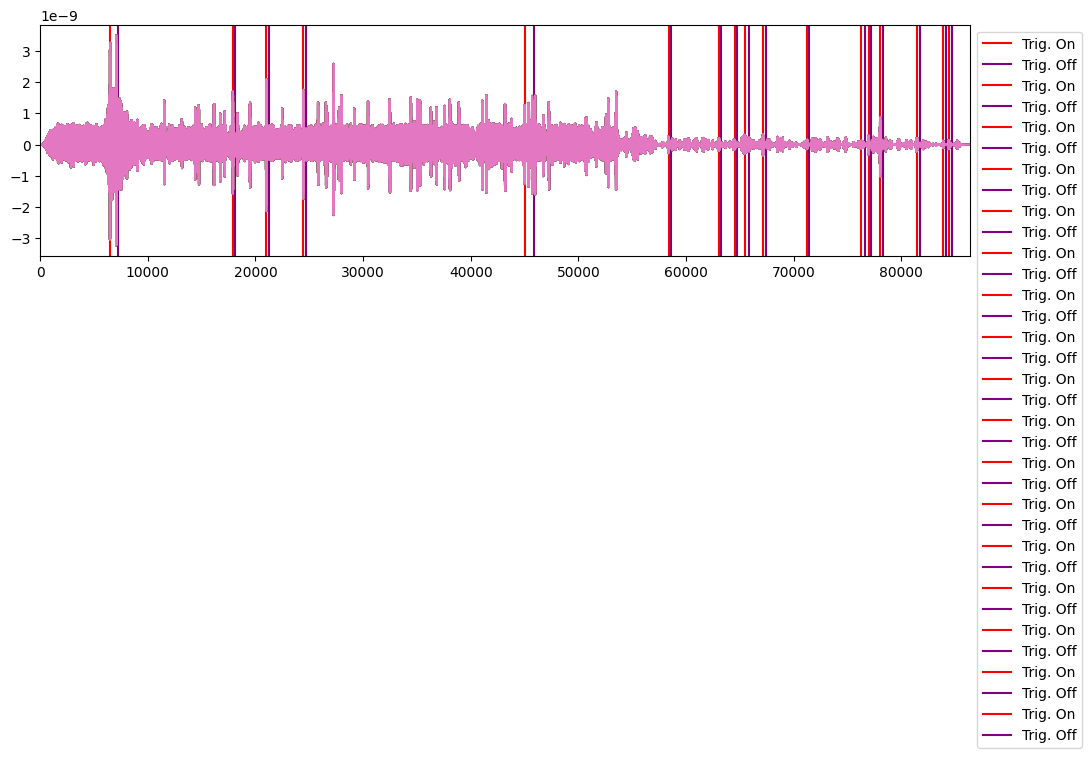

In [9]:
nombre_archivo = 'xa.s12.00.mhz.1973-06-18HR00_evid00109'
planeta = 'luna'
if planeta.lower() == "luna":
    ruta_entrenamiento = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
elif planeta.lower() == "marte":
    ruta_entrenamiento = '/content/drive/My Drive/NASA/data/mars/training/data/'
else:
    raise ValueError("El planeta debe ser 'luna' o 'marte'")
data = read(f"{ruta_entrenamiento}{nombre_archivo}.mseed")
tr = data.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
fila_cat = cat[cat['filename'] == nombre_archivo].iloc[0]
arrival_time = datetime.strptime(fila_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()

df = tr.stats.sampling_rate
sta_len = 180
lta_len = 1200
thr_on = 4
thr_off = 0.5

cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0, len(on_off)):
    triggers = on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))



In [16]:
tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat, nombre_archivo, ruta_entrenamiento)

In [17]:
df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})

In [18]:
X = df['velocity'].values

In [19]:
window_size = 50
n_trees = 100
max_depth = 10
sample_frac = 0.5

anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)

In [20]:
scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)

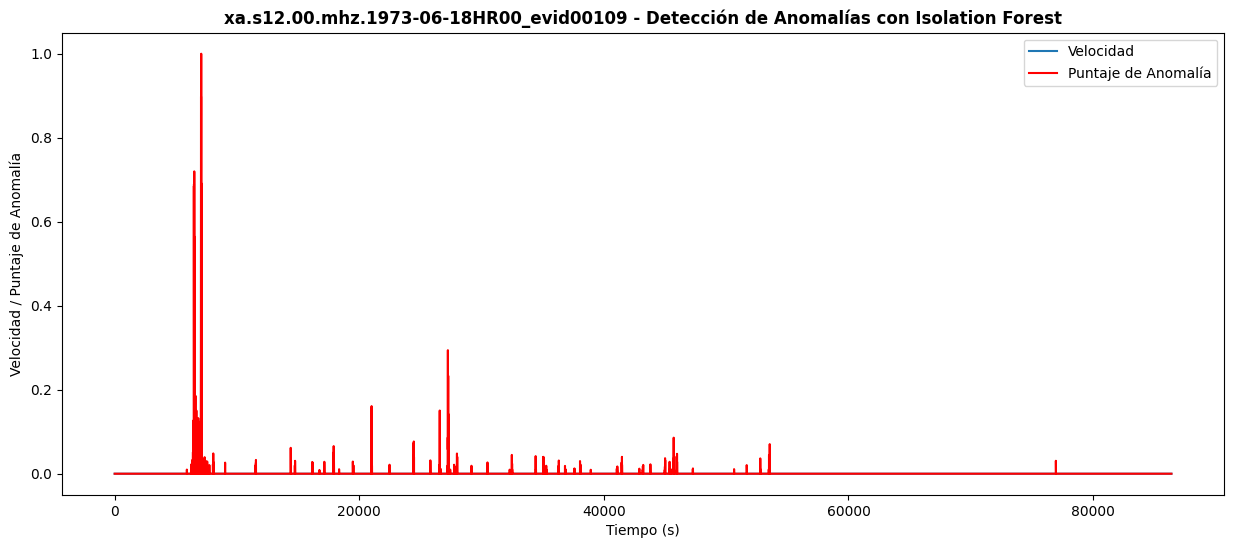

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['velocity'], label='Velocidad')
plt.plot(window_times, scaled_anomaly_scores, label='Puntaje de Anomalía', color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad / Puntaje de Anomalía')
plt.title(f'{nombre_archivo} - Detección de Anomalías con Isolation Forest', fontweight='bold')
plt.legend()
plt.show()

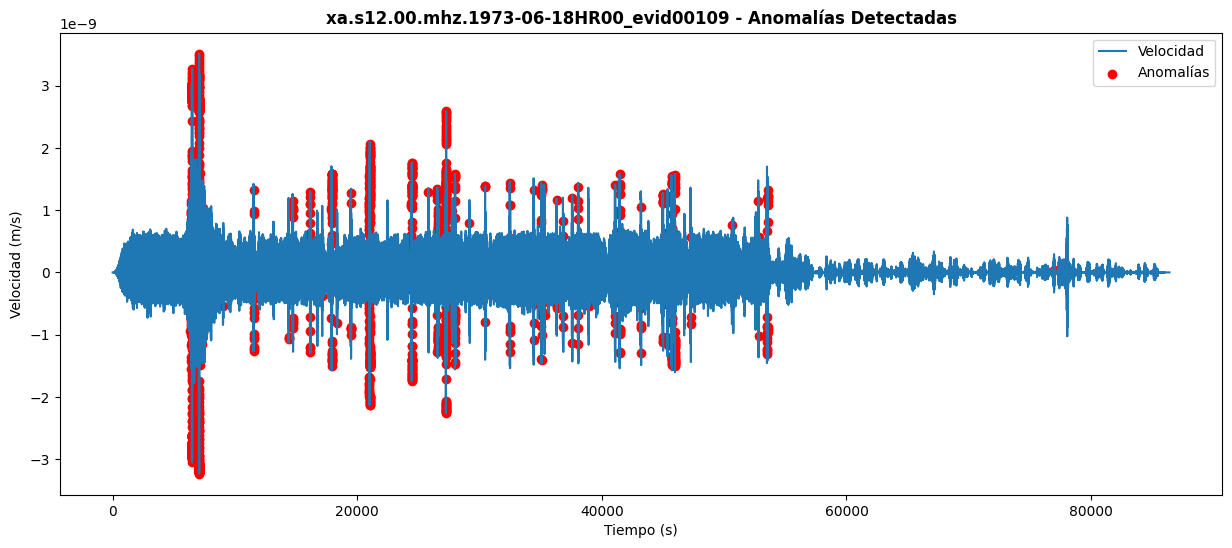

In [23]:
threshold = np.percentile(anomaly_scores, 95)
anomalies = anomaly_scores > threshold
anomaly_times = window_times[anomalies]

plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['velocity'], label='Velocidad')
plt.scatter(anomaly_times, df['velocity'].iloc[anomaly_times.index], color='red', label='Anomalías')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title(f'{nombre_archivo} - Anomalías Detectadas', fontweight='bold')
plt.legend()
plt.show()